# Anchor-Anchor Output Distance
**Goal**: Analyze the distance between the output representation of each set of anchors

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
sns.set_style('darkgrid')

# Load Data

In [2]:
LAYER = 'output'
TYPE = 'anchor'

In [3]:
# Load anchor-probes mapping
anchor_probe_mapping = pd.read_pickle(f'../../dataset/anchor_probe_mapping_dilution_3.pkl')
anchor_probe_mapping = anchor_probe_mapping.rename(columns={'probes': 'probe'})
anchor_probe_mapping.head()

,anchor,probe,type
0,"[slit, dit, yit]","[vlit, plit, trit, drit]",REG
1,"[thax, chax, brax]","[frax, drax, prax, shrax]",REG
2,"[kleef, pleef, smeef]","[bleef, gleef, creef, preef]",REG
3,"[krim, plim, drim]","[blim, clim, shrim, frim]",REG
4,"[nisp, fisp, chisp]","[bisp, kisp, risp, tisp]",REG


In [4]:
all_data = []

for dilution in tqdm(range(1, 4)):
    word_list = sum(anchor_probe_mapping[TYPE].apply(lambda x: x[:dilution]).tolist(), [])
    word_types = [f"{'ANC' if TYPE == 'anchor' else 'PRO'}_{i}" for i in ['REG', 'EXC', 'AMB']]
    
    # Load probes data
    data = pd.concat([pd.read_pickle(f'pmsp-recurrent-dt-100-seed-1/activations-{TYPE}s-{LAYER}.pkl'),
                      pd.read_pickle(f'pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-{TYPE}s-{LAYER}.pkl')])
    
    data = data[data['word_type'].isin(word_types)]
    data = data[data['orth'].isin(word_list)]
    data = data.drop_duplicates(subset=['epoch', 'orth'])
    data['dilution'] = dilution
    all_data.append(data)

all_data = pd.concat(all_data).reset_index(drop=True)


100%|██████████| 3/3 [00:13<00:00,  4.62s/it]


In [5]:
all_data.head()

,epoch,output,word_id,orth,phon,word_type,target,dilution
0,0,"[0.9952428, 0.8635025, 0.7184864, 0.9981539, 0...",4,nisp,nisp,ANC_REG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1,0,"[0.9932049, 0.9132536, 0.2636496, 0.995957, 0....",0,slit,slit,ANC_REG,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,0,"[0.9690626, 0.779036, 0.693073, 0.9947203, 0.5...",34,drace,dro,ANC_EXC,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,0,"[0.9674417, 0.9495515, 0.5947738, 0.99893, 0.2...",8,shing,SiN,ANC_REG,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,0,"[0.9907501, 0.7661552, 0.7772405, 0.9923164, 0...",39,suff,sUf,ANC_EXC,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1


## Calculation of Distance

We use two distance metrics - cosine distance, and L1 distance. The documentation for these two distance metrics are available here:
* [Cosine Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html#sklearn.metrics.pairwise.cosine_distances)
* [Manhattan Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.manhattan_distances.html#sklearn.metrics.pairwise.manhattan_distances)

In [6]:
results = []
for dilution in [2, 3]:
    data = all_data[all_data['dilution'] == dilution]

    for i, row in tqdm(anchor_probe_mapping.iterrows(), total=len(anchor_probe_mapping), desc=f"Dilution {dilution}"):
        word_data = data[data['orth'].isin(row[TYPE])]
        for epoch in data['epoch'].unique():
            epoch_data = np.array(word_data[word_data['epoch'] == epoch][LAYER].tolist())

            results.append({
                'dilution': dilution,
                'epoch': epoch,
                f'{TYPE}s': row[TYPE],
                'type': row['type'],
                'cosine_distances': cosine_distances(epoch_data, epoch_data),
                'l1_distances': manhattan_distances(epoch_data, epoch_data)
            })

Dilution 3: 100%|██████████| 27/27 [00:02<00:00,  9.94it/s]


In [7]:
results_df = pd.DataFrame(results)
results_df['mean_cosine_distance'] = results_df['cosine_distances'].apply(lambda x: x.mean())
results_df['mean_l1_distance'] = results_df['l1_distances'].apply(lambda x: x.mean())
results_df[f'first_{TYPE}'] = results_df[f'{TYPE}s'].apply(lambda x: x[0])
results_df = results_df.sort_values(by=['epoch', 'type', f'first_{TYPE}']).reset_index(drop=True)

In [8]:
results_df.head()

,dilution,epoch,anchors,type,cosine_distances,l1_distances,mean_cosine_distance,mean_l1_distance,first_anchor
0,2,0,"[blome, clome, flome]",AMB,"[[0.0, 0.0047941674523317435], [0.004794167452...","[[0.0, 2.4261134642629996], [2.426113464262999...",0.002397,1.213057,blome
1,3,0,"[blome, clome, flome]",AMB,"[[0.0, 0.002465350485936546, 0.004794167452331...","[[0.0, 1.9934024260059997, 2.4261134642629996]...",0.002560,1.548015,blome
2,2,0,"[clead, smead, pread]",AMB,"[[0.0, 0.007933617393577563], [0.0079336173935...","[[0.0, 3.441131358188], [3.441131358188, 0.0]]",0.003967,1.720566,clead
3,3,0,"[clead, smead, pread]",AMB,"[[0.0, 0.007933617393577563, 0.011071806993381...","[[0.0, 3.441131358188, 4.005879769688001], [3....",0.006251,2.446964,clead
4,2,0,"[frow, clow, trow]",AMB,"[[0.0, 0.008505226284223677], [0.0085052262842...","[[0.0, 3.5191756533780003], [3.519175653378000...",0.004253,1.759588,frow


In [9]:
results_df = results_df[results_df['epoch'] >= 100]

## Mean Cosine and L1 Distance by Type

This first pair of graphs aggregate dilution 2 and 3 together.

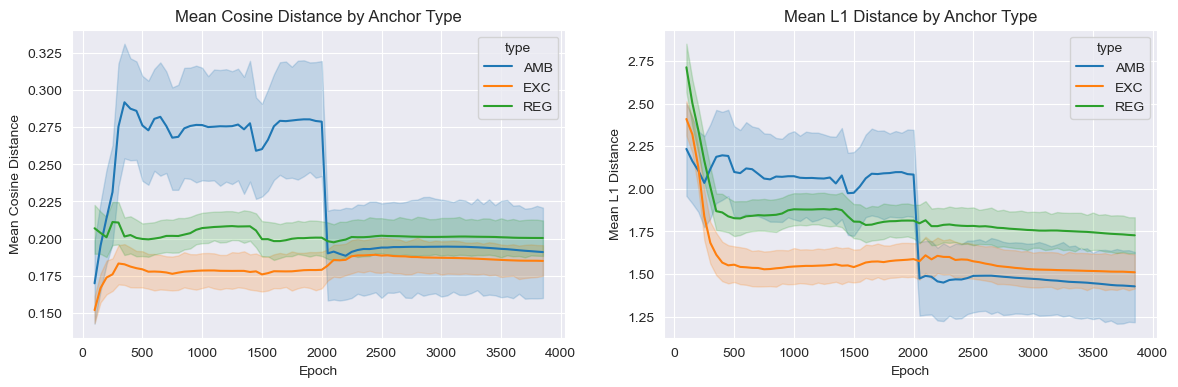

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.lineplot(data=results_df, x='epoch', y='mean_cosine_distance', hue='type', ax=ax1, ci=68)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Cosine Distance')
ax1.set_title(f'Mean Cosine Distance by {TYPE.title()} Type')

sns.lineplot(data=results_df, x='epoch', y='mean_l1_distance', hue='type', ax=ax2, ci=68)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean L1 Distance')
ax2.set_title(f'Mean L1 Distance by {TYPE.title()} Type')

plt.show()

In the next 3 sets of graphs, we look at each regularity type individually, but combine all three dilution levels in the same plot.

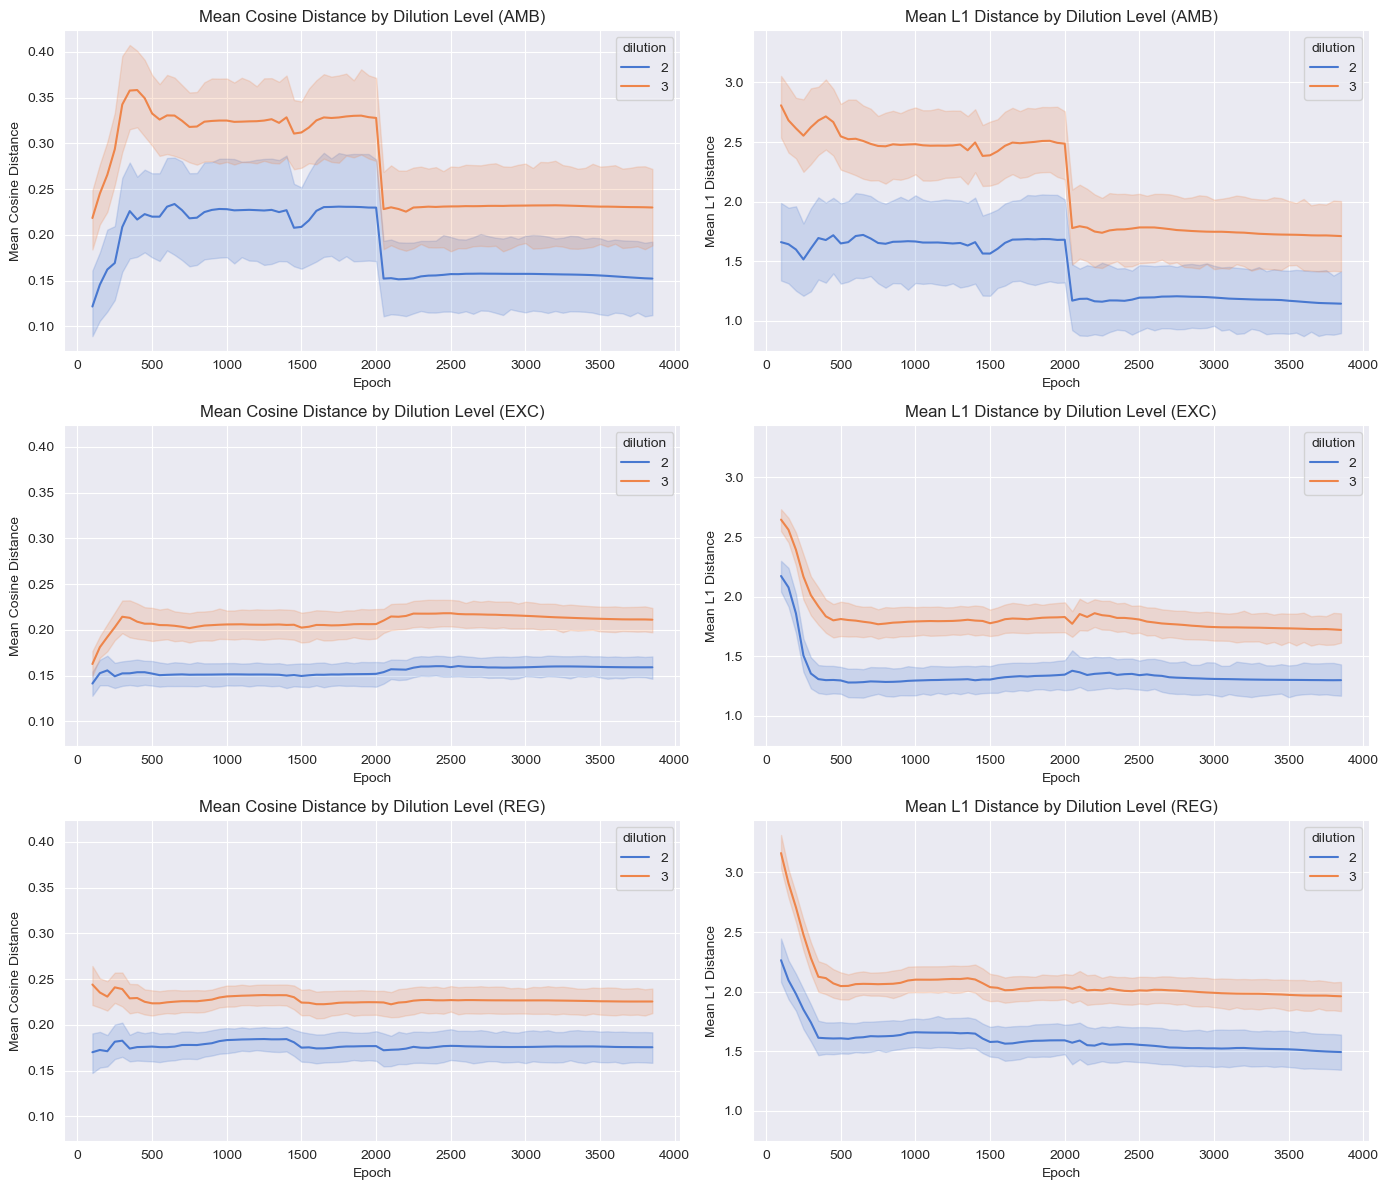

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for word_type, ax in zip(results_df['type'].unique(), axs):
    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_cosine_distance', hue='dilution',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Dilution Level ({word_type})')

    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_l1_distance', hue='dilution',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Dilution Level ({word_type})')

plt.tight_layout()
plt.show()

In the next 3 sets of graphs, we look at each dilution level individually, but combine all three regularity types in the same plot.

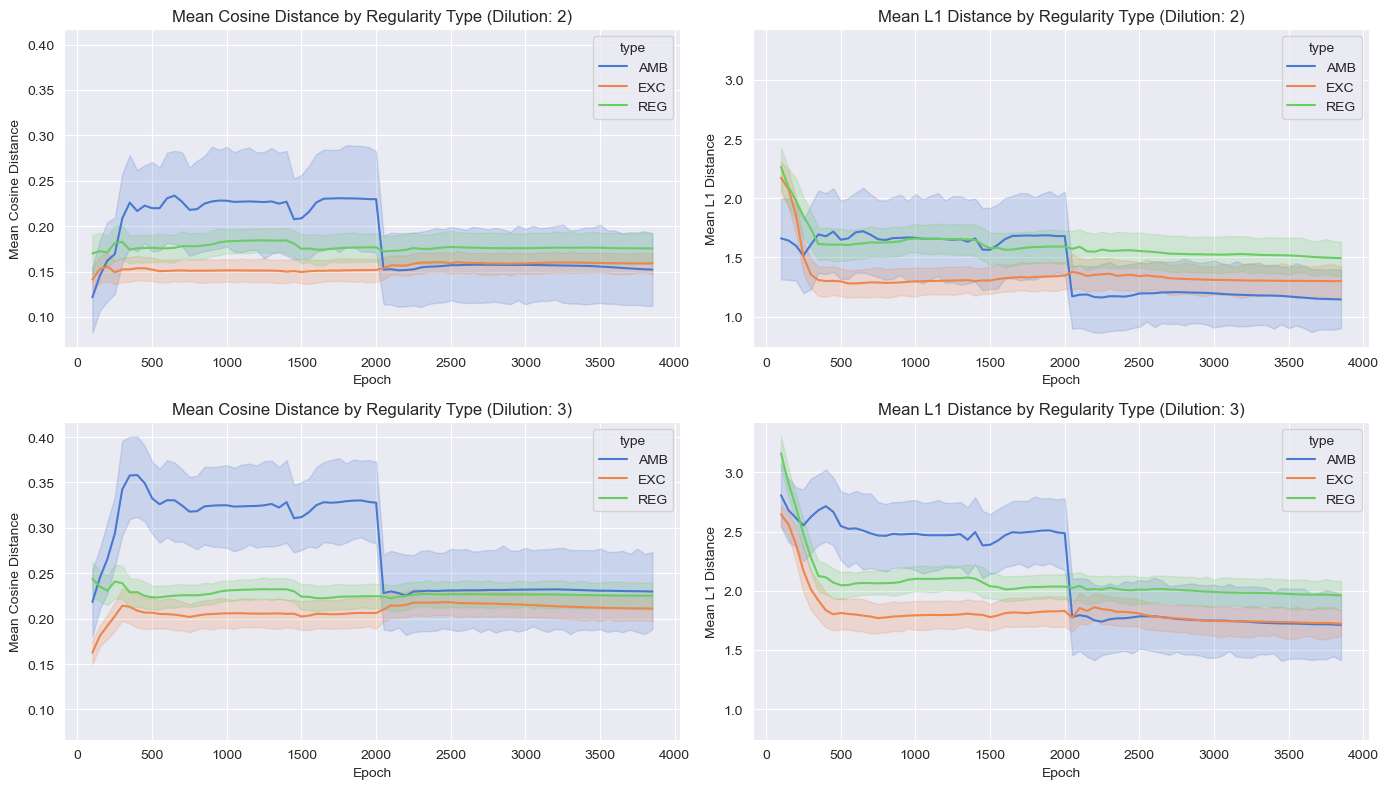

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharey='col')

for dilution, ax in zip(results_df['dilution'].unique(), axs):
    sns.lineplot(data=results_df[results_df['dilution'] == dilution], x='epoch', y='mean_cosine_distance', hue='type',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Regularity Type (Dilution: {dilution})')

    sns.lineplot(data=results_df[results_df['dilution'] == dilution], x='epoch', y='mean_l1_distance', hue='type',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Regularity Type (Dilution: {dilution})')

plt.tight_layout()
plt.show()

## Distance by Word Set
* We refer to each anchor/probe set by the first anchor/probe.

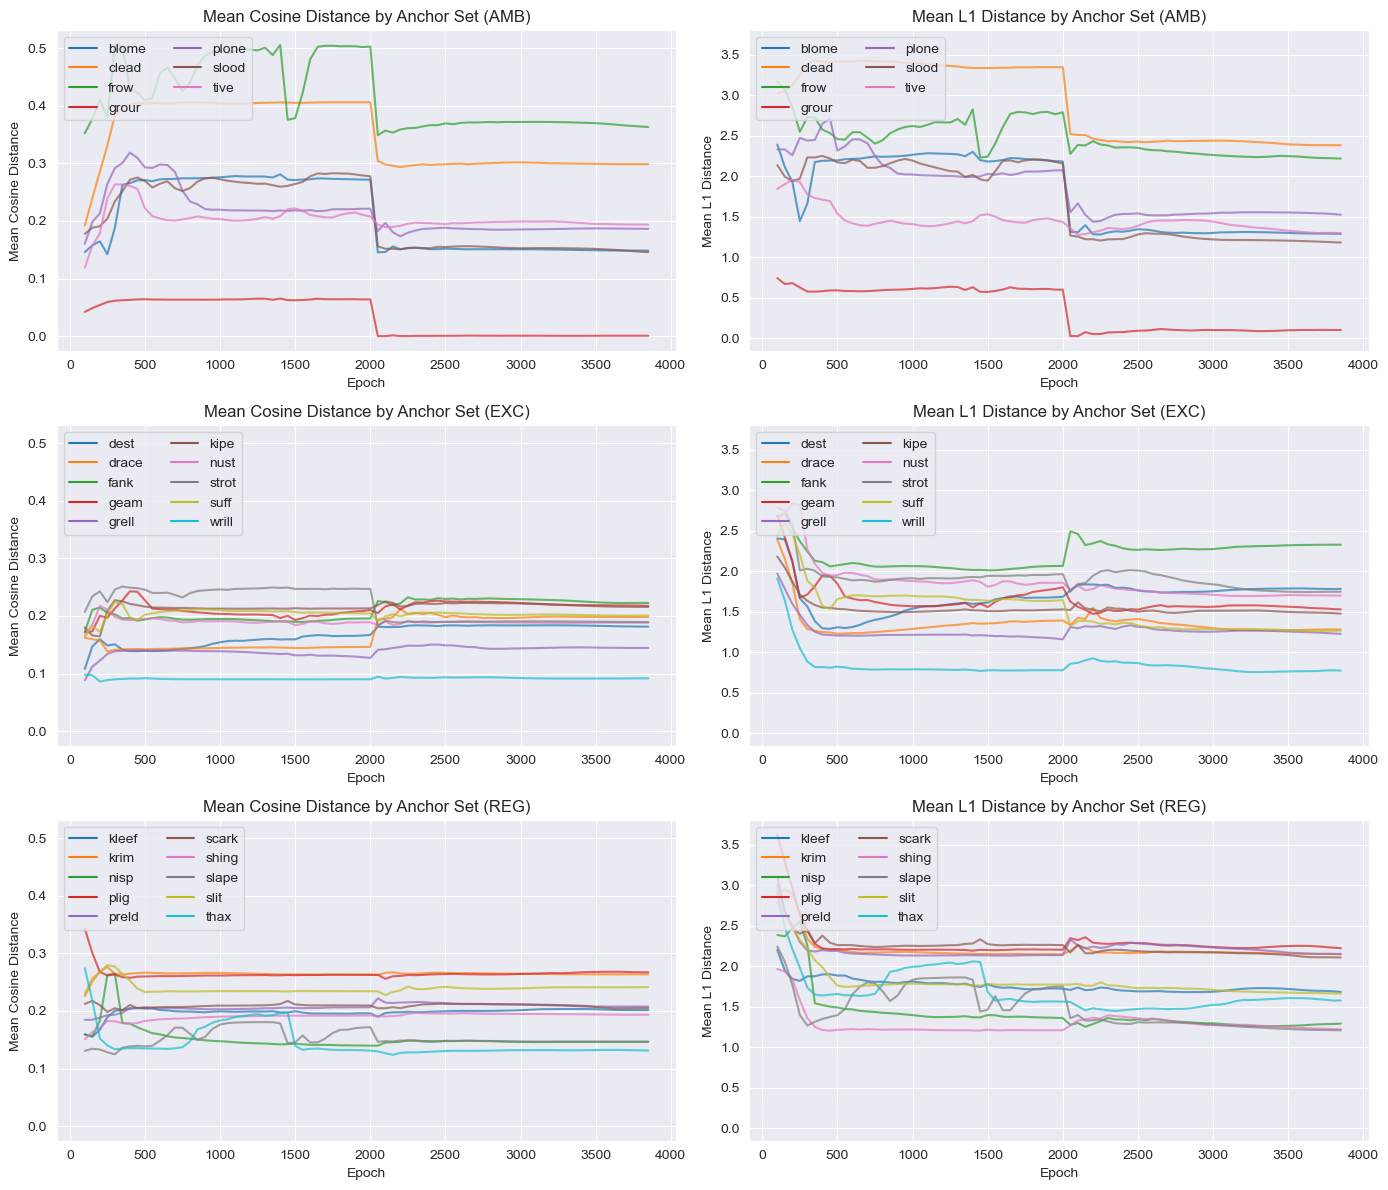

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for word_type, ax in zip(results_df['type'].unique(), axs):
    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_cosine_distance', hue='first_anchor',
                 alpha=0.7, ax=ax[0], ci=None)
    ax[0].legend(ncol=2, loc='upper left')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by {TYPE.title()} Set ({word_type})')

    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_l1_distance', hue='first_anchor',
                 alpha=0.7, ax=ax[1], ci=None)
    ax[1].legend(ncol=2, loc='upper left')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by {TYPE.title()} Set ({word_type})')

plt.tight_layout()
plt.show()

## Why is distance for 'grour' zero?

In [14]:
grour_data = results_df[results_df['first_anchor'] == 'grour']

In [15]:
grour_data

,dilution,epoch,anchors,type,cosine_distances,l1_distances,mean_cosine_distance,mean_l1_distance,first_anchor
114,2,100,"[grour, grour, frour]",AMB,[[0.0]],[[0.0]],0.000000,0.000000,grour
115,3,100,"[grour, grour, frour]",AMB,"[[0.0, 0.16837679471964107], [0.16837679471964...","[[0.0, 2.9646825181999983], [2.964682518199998...",0.084188,1.482341,grour
168,2,150,"[grour, grour, frour]",AMB,[[0.0]],[[0.0]],0.000000,0.000000,grour
169,3,150,"[grour, grour, frour]",AMB,"[[0.0, 0.1949904909199074], [0.194990490919907...","[[0.0, 2.670902801635001], [2.670902801635001,...",0.097495,1.335451,grour
222,2,200,"[grour, grour, frour]",AMB,[[0.0]],[[0.0]],0.000000,0.000000,grour
...,...,...,...,...,...,...,...,...,...
4057,3,3750,"[grour, grour, frour]",AMB,"[[0.0, 0.0030992287448466938], [0.003099228744...","[[0.0, 0.4020109328574001], [0.402010932857400...",0.001550,0.201005,grour
4110,2,3800,"[grour, grour, frour]",AMB,[[0.0]],[[0.0]],0.000000,0.000000,grour
4111,3,3800,"[grour, grour, frour]",AMB,"[[0.0, 0.0030061821682154655], [0.003006182168...","[[0.0, 0.39943764112999997], [0.39943764112999...",0.001503,0.199719,grour
4164,2,3850,"[grour, grour, frour]",AMB,[[0.0]],[[0.0]],0.000000,0.000000,grour
